# Traveltime tomography exercise
Created by Michele Paulatto, Imperial College London

https://github.com/michpaulatto/AppliedGeophysicsExercises

Developed for Google Colab

# Introduction
This is an exercise to demonstrate traveltime tomography. This environment is a Jupyter notebook (https://jupyter.org/), an open-source application for creating interactive modular code. This exercise is written in the Python programming language. You do not need to be an expert in Python or Jupyter to run through the exercise.

For a refresher on Python check out this exercise:

https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb

For a specific intro on Colab check out the following exercise:

https://colab.research.google.com/notebooks/basic_features_overview.ipynb

The main tool we use is a library called Pygimli:

https://www.pygimli.org/pygimliapi/index.html

Further exercises can be found here:

https://www.pygimli.org/_examples_auto/index.html

# Environment setup
We need to set up the Python environment before we start. If running the exercise on your local machine the setup would have to be modified. We need to install Anaconda (https://www.anaconda.com/) and use it to install Pygimli. Some of the operations in the setup are a bit advanced and are beyond the scope of this exercise. So just run the following two code cells and move on. This may take a couple of minutes so be patient. If running this Notebook on Google Colab you may get a warning that the Notebook was not authored by Google, click OK and continue.

In [1]:
%%bash
PYTHONPATH=""
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT &> setup.log
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &>> setup.log
echo "Miniconda installed"

Miniconda installed


In [2]:
!conda install --channel defaults conda python=3.6 --yes &>> setup.log
!conda update --channel defaults --all --yes &>> setup.log
print("Anaconda updated and set up")
import sys
sys.path
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

!conda install pygimli -c gimli -c conda-forge --yes &>> setup.log
print("Pygimli installed")

Anaconda updated and set up
Pygimli installed


# Python modules
Here we load the python modules that we will need for the exercise, including Pygimli.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.traveltime import TravelTimeManager
from pygimli.viewer.mpl import drawMesh
pg.utils.units.quants['vel']['cMap'] = 'inferno_r'

20/01/21 - 21:36:33 - pyGIMLi - INFO - Creating default user configuration file at /root/.config/pygimli/config.json


# Geometry set up
Here we create some meshes that we will use to define the velocity models.
We create a mesh that will serve as our "true" model (mesh_for) and a mesh that will serve as a background model (mesh_bg). The true model contains two elliptical anomalies that we will try to recover with the traveltime inversion. The background model will be used as the starting model for the inversion.
The mesh files only contain information on the geometry of the model parameterisation and no information on the seismic velocity. 

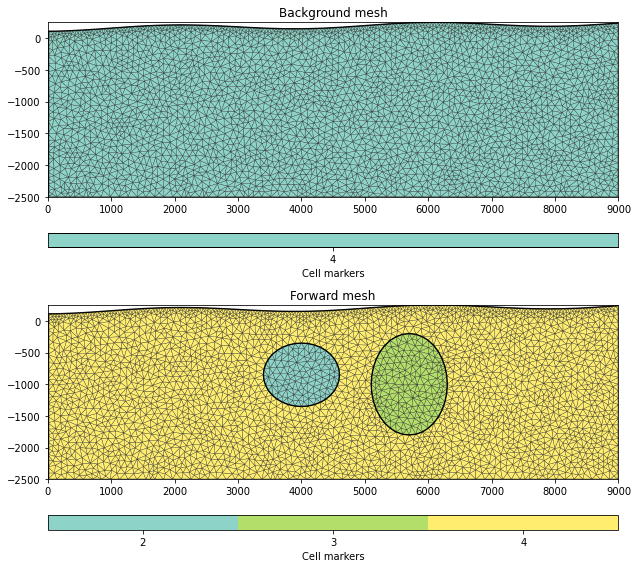

In [4]:
# Create elliptical anomalies. Youc an change the size and location of the anomalies to customise your model
# Anomaly 1:
magma = mt.createCircle(pos=[4000.0, -850.], segments=36, radius=[600.0, 500.0], marker=2,
                        area=8000.0)
# Anomaly 2:
pluton = mt.createCircle(pos=[5700.0, -1000.], segments=36, radius=[600.0, 800.0], marker=3,
                        area=8000.0)
# Define a function to create land topography 
def surf(x):
    y =150 - 40 * np.cos(2 * np.pi * 1/4000 * x) +x*0.01
    return y

# We define the location of sources here so that we can give each one a node in the mesh
# shots every 50 m at the surface
shotsx = np.arange(0., 9050.,50.0)
shotsy = surf(shotsx)
# Receivers every 500 m at the surface
obsx = np.arange(500.0, 9000.0, 500.)
obsy = surf(obsx)

# Create topography
topo = [[x,surf(x)] for x in shotsx]
topo.append([9000,-2500])
topo.append([0,-2500])

# Create main polygon for the mesh with topography as top surface
main = mt.createPolygon(topo,area=8000,isClosed=True, marker=4)
plc = main
    
# Merge polygons into a single mesh for true model and background model
# The variable "quality" sets the quality of the mesh. A property related to the
# accuracy of the solution. 
# The variable "area" sets the maximum area of each cell in the mesh in m^2.
mesh_for = mt.createMesh(plc + magma + pluton, quality=32, area=8000)
# The background model doesn't include the elliptical anomalies
mesh_bg = mt.createMesh(plc, quality=32, area=8000)

# Plot meshes
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg,markers=True, showMesh=True,ax=ax[0])
pg.show(mesh_for,markers=True, showMesh=True,ax=ax[1])
ax[0].set_title("Background mesh")
ax[1].set_title("Forward mesh")
fig.tight_layout()

# Velocity model
Here we add velocity information to the meshes.
We create a background velocity by "hanging" a 1d velocity model to the surface topography. The true model is built by adding the velocity anomalies and a random perturbation to the background model. The velocity information is stored in separate variables from the mesh files. The random field generator used to create a random perturbation is a bit slow so this may take a couple of minutes.

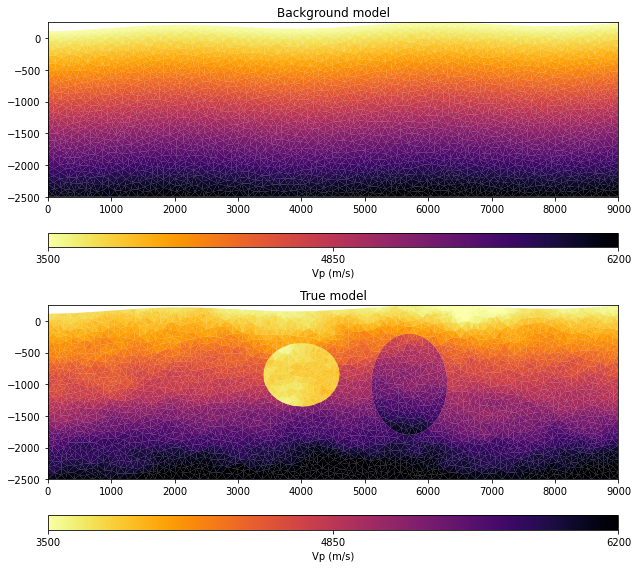

In [5]:
# Remove boundary markers
for boundary in mesh_for.boundaries():
    boundary.setMarker(0)
for boundary in mesh_bg.boundaries():
    boundary.setMarker(0)

# Initialise lists that will contain the velocity information
vel_for = []
vel_bg = []
# Define background velocity model
a = 3500  # Vp value at the surface in m/s
b = 1.0   # Vertical Vp gradient in (m/s)/m
# Create velocities "hanging" from topography
for node in mesh_bg.nodes():
    vel_bg.append(a+b*(abs(node.y()-surf(node.x()))))    
for node in mesh_for.nodes():
    vel_for.append(a+b*(abs(node.y()-surf(node.x()))))

# Add velocity info to mesh
vel_for = pg.meshtools.nodeDataToCellData(mesh_for,np.array(vel_for))
vel_bg = pg.meshtools.nodeDataToCellData(mesh_bg,np.array(vel_bg))

# Create reference model with forward mesh for plotting calculating velocity anomaly
vel_for_ref = []
for node in mesh_for.nodes():
    vel_for_ref.append(a+b*(abs(node.y()-surf(node.x()))))
vel_for_ref = pg.meshtools.nodeDataToCellData(mesh_for,np.array(vel_for_ref))


# Add anomalies to velocity model
c = 3600  # Vp value inside anomaly 1
d = 400   # Vp anomaly inside anomaly 2
for i,cell in enumerate(mesh_for.cells()):
    if cell.marker() == 2:
        vel_for[i] = c
    elif cell.marker() == 3:
        vel_for[i] = vel_for[i]+d

# Add random perturbations to true model. You can change the strength of the random perturbation to see how it affects the inversion.
strength = 100
random = pg.utils.generateGeostatisticalModel(mesh_for, I=[1000, 500])
vel_for = vel_for+random*strength     

# Plot background model and true model
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg, vel_bg, label="Vp (m/s)",ax=ax[0],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
pg.show(mesh_for, vel_for, label="Vp (m/s)",ax=ax[1],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
ax[0].set_title("Background model")
ax[1].set_title("True model")
fig.tight_layout()

# Experiment set up
Here we define the acquisition geometry of the experiment and define the variable that we need to simulate the ray propagation.

In [6]:
from itertools import product

# Define shot locations
shots = np.zeros((len(shotsx), 2)) 
shots[:, 0] = shotsx  # x
shots[:, 1] = shotsy

# Define receiver locations
obss = np.zeros((len(obsx), 2)) 
obss[:, 0] = obsx  # x
obss[:, 1] = obsy

# Create labels for the shots
shotsn = np.arange(len(shotsx))
# Find a label for each receiver that correspond to the shot at that position
obsn = []
for i in shotsn:
    if shotsx[i] in obsx:
        obsn.append(i)     

# Define source-receiver pairs 
rays = list(product(obsn,shotsn))

# Remove pairs were source and receiver are close to each other
# You can modify this to exclude short offsets or long offsets from your inversion
remove=[]
for i,r in enumerate(rays):
    if abs(r[0] - r[1]) < 2 :
        remove.append(r)        
for r in remove:
    rays.remove(r)
    
# Create empty data container
scheme = pg.DataContainer()        

# Add shots and receivers as "sensors". Pygimli doesn't distinguish
# between sources and receivers. They are all called "sensors".
for i in shotsn:
    scheme.createSensor((shotsx[i],shotsy[i]))

# Add measurements, i.e. read the source-receiver pairs defined above
rays = np.array(rays)
scheme.resize(len(rays))
scheme["s"] = rays[:, 0]
scheme["g"] = rays[:, 1]
scheme["valid"] = np.ones(len(rays))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")
print("Done")

Done


# Calculate traveltimes and draw raypaths
Here we calculate synthetic traveltimes for the true model. These will be our data for the following inversion so we call them *tobs* (for observed travel times).

The traveltimes can be calculated with a range of different method. In this exercise we use the "graph" method based on the work of computer scientist Edsger W. Dijkstra. His algorithm was designed to find the shortest path between points on a graph. A "graph" in this case is a set of nodes connected by segments, think for example of finding the shortest route from one address to another in central London.

The traveltimes calculation uses a modified version of the Dijkstra algorithm that finds the path of minimum traveltime between each source and receiver pair. This is not as simple as finding the minimum distance, because the speed of propagation changes throughout the model so the shortest path is not always the quickest. In our case the network of nodes is the mesh defined above.

**Question 1** Why is the graph method a good way for calculating the first arrival traveltimes? Are there any disadvantages?

In [7]:
# Initialise traveltime manager
vel_run = vel_for
mesh_run = mesh_for
tt = TravelTimeManager()
secnodes=5  # Number of secondary nodes

pg.tic()
tobs = tt.simulate(mesh=mesh_run, scheme=scheme, slowness=1./vel_run,secNodes=secnodes,
                 verbose=1,debug=True,noiseAbs=0.0005)
pg.toc("Raytracing with %d secondary nodes:" % secnodes)
print("Done")

20/01/21 - 21:38:50 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 11.03 seconds.
Done


# Plotting the ray paths
Here we plot the paths of the rays calculated in the previous step. Notice how the rays "avoid" the low velocity anomaly.

**Question 2** Why are the rays avoiding the low velocity anomaly? Remember that we are calculating the first arrival traveltimes.

**Question 3** What will be the consequences of the rays avoiding the low velocity anomaly on the ability of the inversion to recover the structure?

**Question 4**: Notice the maximum depth of penetration of the rays (the turning depth). How could we change the experiment geometry to sample deeper into the subsurface? What else could we do to sample deeper?

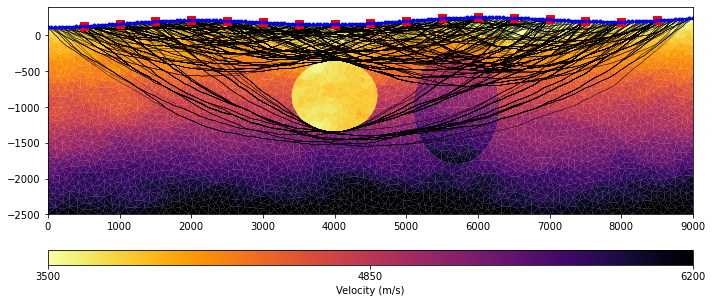

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot the velocity model
pg.show(mesh_run, vel_run, ax=ax, label="Velocity (m/s)", hold=True,
       logScale=False, cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)

# Plot rays
tt.drawRayPaths(ax=ax, model=vel_run, color="k", lw=0.3, alpha=0.5)
ax.plot(obsx, obsy, "rs", ms=8)     # plot receivers as red squaress
ax.plot(shotsx, shotsy, "bo", ms=3) # plot shots as blue dots
ax.set_ylim(mesh_run.ymin(), 400)   # set y axis limits
fig.tight_layout()

# Ploting the traveltimes
Here we plot the synthetic observed traveltimes. Traveltimes for each receiver are plotted in a different color.

**Question 5** What is the signature of the low velocity anomaly in the traveltime curves?

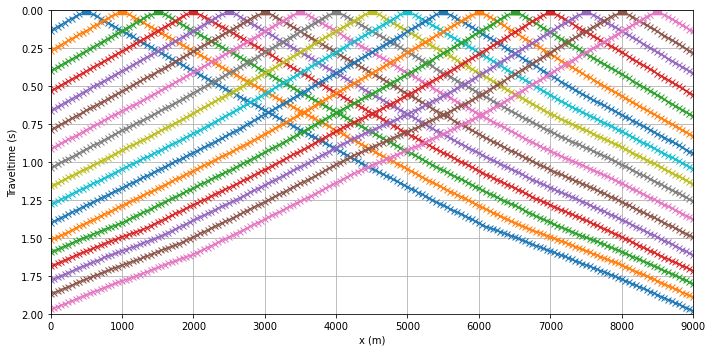

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim(0, 2.0)
ax.set_xlim(0, 9000)
pg.physics.traveltime.drawFirstPicks(ax, tobs)
fig.tight_layout()



# Inversion
Here we carry out an inversion of the observed traveltimes *tobs* calculated above. The observed traveltimes represent our data. The goal is to match the data and recover the anomalies of the true model. Our starting model is the background velocity model.

The inversion is an iterative process. At each iteration we need to trace the rays and calculate the traveltimes so that we can compare them to the data and calculate the traveltime residuals. We then update the model to minimise the traveltime residuals. In practise we minimise the sum of the squares of the residuals weighted by the data undertainties. Therefore we call this problem as "least squares minimisation".

# Pitfalls
You can see from the ray paths plotted above that the data coverage is irregular and incomplete, this makes the problem of inverting the data "ill posed". The irregular and patchy "illumination" means that a wide range of models may exist that all satisfy the data. This set of plausible models is called the null-space. Any noise that exists within the null space will be unconstrained during the inversion and can make the problem unstable

The relationship between the model parameters (the velocity values at the grid nodes) and the traveltimes is also non-linear and this may lead to local minima in the minimisation. In other words the inversion may get stuck and fail to converge to the global minimum of the least squares objective function.

To contrast these issues we stabilize the inversion with regularization. The regularization adds a second term to the objective function that we are minimizing at the same time as we minimize the residuals. In this case the regularization term is the roughness of the model, calculated as the second spatial derivative of the velocity distribution. By minimising the regularization term we favour models that have low roughness (i.e. are smoother).

# Tuning the inversion
The regularization term is weighted by a constant lambda. A higher lambda favors smoother models. To choose the appropriate value of lambda we study the trade-off curve between the misfit term (the data norm) and the regularization term (the model norm). Because of its shape this trade-off curve is often called the L-curve. To generate the L-curve we would have to run multiple inversion, each with a different value of lambda an we would then plot the the data norm vs. the model norm for the final model of each inversion. This would take more time than we have available for this tutorial so I have calculated the L-curve in advance for you. 

![](https://raw.githubusercontent.com/michpaulatto/AppliedGeophysicsExercises/main/Images/lcurve.png)

**Question 6** Study the L-curve. What is an appropriate value for the regularization strength lambda? Pick a value and then insert it in the cell below and continue.

In [17]:
# Enter the value of the regularization weight lambda
# in the form on the right
lam =  1e4#@param {type:"number"}

# Choosing a final model
How do we chose when to stop the inversion?
An iterative inversion presents a dilemma: if at each iteration we get closer to the "true model", how do we choose when to stop? Here we use three separate criteria:
- When the $\chi^2 $ is 1. The $\chi^2$ is a measure of how closely the predicted traveltimes fit the data. A $\chi^2$ of 1 means that we can fit the data to within the given uncertainty.
- When the inversion converges. If the improvement at each step is very small we can stop the inversion. We can set this with the parameter dPhi. This represents the minimum improvement in the data norm (the total misfit) and is initially set to 1%. If dPhi goes below this value we stop the inversion.
- When we run out of time. If the inversion is not well tuned it may not converge. In this case we stop the inversion after 20 iterations.

In [11]:
# Run the Inversion
invmodel = tt.invert(tobs, mesh=mesh_bg, startModel=1./vel_bg, secNodes=5,zWeight=0.5, 
          verbose=1, maxiter=20, lam=lam, dPhi=1) 

20/01/21 - 21:39:20 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 21:39:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 21:39:20 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
20/01/21 - 21:39:21 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 21:39:21 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f49ebed7f48>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f49ebec2dc0>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f49ebb7df80>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 7.34 (dPhi = 72.15%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3.04 (dPhi = 52.93%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 2.33 (dPhi = 17.38%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 2.02 (dPhi = 9.7%) lam

# Plot the residuals
Here we trace the rays through the final and starting model and compare the travel time residuals.

20/01/21 - 22:45:16 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
20/01/21 - 22:45:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


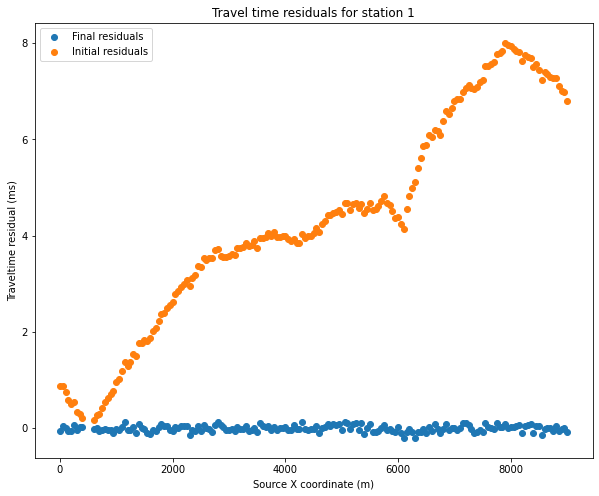

In [18]:
# Initialise traveltime manager
ttinv = TravelTimeManager()
secnodes=5  # Number of secondary nodes
tinv = ttinv.simulate(mesh=mesh_bg, scheme=scheme, slowness=1./invmodel,secNodes=secnodes,
                 verbose=1,debug=True)

ttbg = TravelTimeManager()
secnodes=5  # Number of secondary nodes
tbg = ttbg.simulate(mesh=mesh_bg, scheme=scheme, slowness=1./vel_bg,secNodes=secnodes,
                 verbose=1,debug=True)
# Plot the residuals
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True, sharey=True)
ax.set_title("Travel time residuals for station 1")
ax.axes.set_xlabel('Source X coordinate (m)')
ax.axes.set_ylabel('Traveltime residual (ms)')
plt.scatter(tinv('g')[0:178]*50,((tinv('t')-tobs('t'))[0:178])*100,label='Final residuals')
plt.scatter(tbg('g')[0:178]*50,((tbg('t')-tobs('t'))[0:178])*100,label='Initial residuals')
ax.legend()

# Plotting the final model
Here we plot a comparison of the true model and the recovered model. 

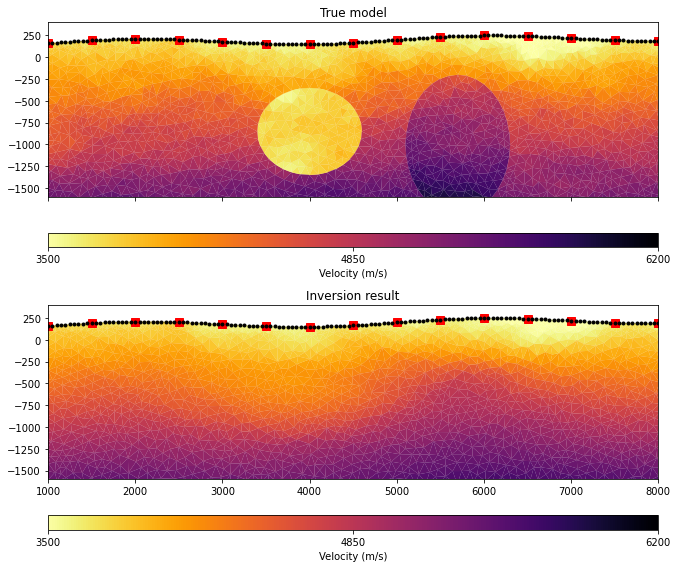

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

pg.show(mesh_for, vel_for, ax=ax1, showMesh=False,
        label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)

tt.showResult(ax=ax2, logScale=False, showMesh=False, nLevs=3,cMin=3500,cMax=6200)

#tt.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
for ax in (ax1, ax2):
    ax.plot(obsx, obsy, "rs", ms=8)
    ax.plot(shotsx, shotsy, "ko", ms=3)
    ax.set_ylim(-1600,400)
    ax.set_xlim(1000,8000)
fig.tight_layout()

# Velocity anomaly
We can more easily evaluate the result if we plot the true and recovered velocity anomaly, i.e. the difference between the model and the background.

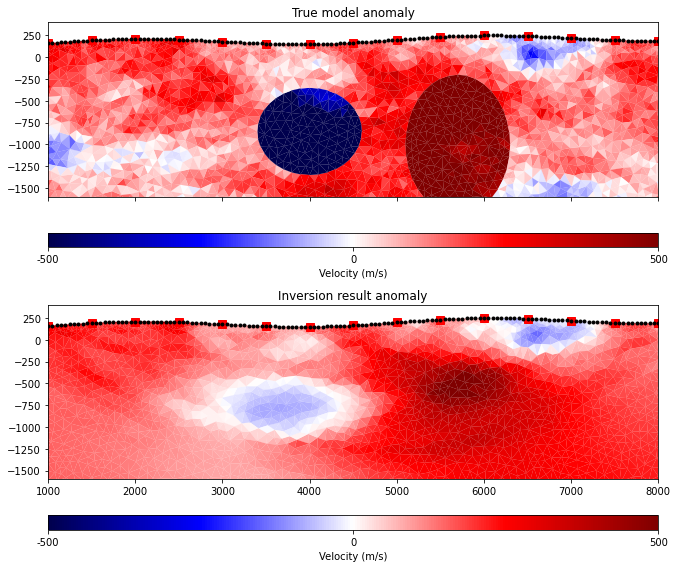

In [15]:
# Subtract the background to get the velocity anomaly
ano_true = vel_for - vel_for_ref
ano_inv = invmodel - vel_bg

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)
ax1.set_title("True model anomaly")
ax2.set_title("Inversion result anomaly")

# Plot the true anomaly
pg.show(mesh_for, ano_true, ax=ax1, showMesh=False,
        label=pg.unit('vel'), cMap='seismic', nLevs=3,cMin=-500,cMax=500)

# Plot the recovered anomaly
pg.show(mesh_bg, ano_inv, ax=ax2, showMesh=False,
        label=pg.unit('vel'), cMap='seismic', nLevs=3,cMin=-500,cMax=500)

# Plot stations and shots
for ax in (ax1, ax2):
    ax.plot(obsx, obsy, "rs", ms=8)
    ax.plot(shotsx, shotsy, "ko", ms=3)
    ax.set_ylim(-1600,400)
    ax.set_xlim(1000,8000)
fig.tight_layout(

# Final remarks
The recovered anomalies are considerably weaker than the true anomalies and they are smeared in the horizontal direction.

**Question 7** How could we do better? Consider 1) the experiment parameters, 2) the inversion parameters and 3) the inversion approach.